# Binary Sentiment Analysis (Work In Progress)
#### by: Eric J. Puttock
##### Last Updated: 2020.09.03

Remark: This notebook will be cleaned up as I continue to work on the project.

Analyzing the IMBD Dataset with 500,000 movie reviews separated into 'positive' or 'negative' sentiment.

Goal: Accurately predict whether the movie review was positive or negative (no neutral zone).

Idea: Train a Recurrent Neural Network to predict the sentiments of a movie review.

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import numpy as np
import keras

In [4]:
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, Conv1D, LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant

In [5]:
movie_reviews = pd.read_csv('IMDB Dataset.csv')

In [6]:
print(movie_reviews.isnull().values.any())
print(movie_reviews.shape)
display(movie_reviews.head(20))

False
(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive
5,"Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a nobl...",positive
6,I sure would like to see a resurrection of a up dated Seahunt series with the tech they have tod...,positive
7,"This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 o...",negative
8,Encouraged by the positive comments about this film on here I was looking forward to watching th...,negative
9,If you like original gut wrenching laughter you will like this movie. If you are young or old th...,positive


In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [9]:
movie_reviews['PPreview'] = movie_reviews['review'].apply(lambda x: preprocess_text(x))

In [10]:
display(movie_reviews.head())

,review,sentiment,PPreview
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,One of the other reviewers has mentioned that after watching just Oz episode you ll be hooked Th...
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive,A wonderful little production The filming technique is very unassuming very old time BBC fashion...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,I thought this was wonderful way to spend time on too hot summer weekend sitting in the air cond...
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,Basically there a family where little boy Jake thinks there a zombie in his closet his parents a...
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,Petter Mattei Love in the Time of Money is visually stunning film to watch Mr Mattei offers us v...


In [11]:
def GoodChecker(sentiment):
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return 0
    else:
        return None
    
movie_reviews['Pos'] = movie_reviews['sentiment'].apply(lambda x: GoodChecker(x))

In [12]:
display(movie_reviews.head())

,review,sentiment,PPreview,Pos
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive,One of the other reviewers has mentioned that after watching just Oz episode you ll be hooked Th...,1
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive,A wonderful little production The filming technique is very unassuming very old time BBC fashion...,1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive,I thought this was wonderful way to spend time on too hot summer weekend sitting in the air cond...,1
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative,Basically there a family where little boy Jake thinks there a zombie in his closet his parents a...,0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive,Petter Mattei Love in the Time of Money is visually stunning film to watch Mr Mattei offers us v...,1


In [13]:
X_train, X_test, y_train, y_test = train_test_split(movie_reviews['PPreview'].reset_index(drop = True),movie_reviews['Pos'].reset_index(drop = True), test_size=0.5, random_state=42, stratify = movie_reviews['Pos'].reset_index(drop = True))

In [65]:
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25000,) (25000,) (25000,) (25000,)


In [15]:
print((y_train==1).sum(), (y_train==0).sum(), (y_test==1).sum(), (y_test==0).sum())

12500 12500 12500 12500


In [14]:
PosRevTrain = X_train[y_train == 1].reset_index(drop=True)
NegRevTrain = X_train[y_train == 0 ].reset_index(drop=True)
PosRevTest = X_test[y_test == 1].reset_index(drop=True)
NegRevTest = X_test[y_test == 0].reset_index(drop=True)

In [15]:
PosRevTest[0]

'While there aren any talking animals big lavish song production numbers or villians with half white half black hair it does have thing realistic people acting normally in strange circumstance and Walt Roy did in their eras with the studio If you thought think The Castaways or The Island At The Top Of The World weren identical or you hold them to higher authority than Atlantis then your idealism is just as whacked as keeping your kids up till midnight to watch friggin cartoon '

In [16]:
# Combine all reviews for the desired sentiment
PosTrain_text = " ".join([review for review in PosRevTrain])
NegTrain_text = " ".join([review for review in NegRevTrain])

In [ ]:
# Attempting to remove some common terms that don't really express much emotion.
CommonWords = ['br','film','movie','see','time','character','story']

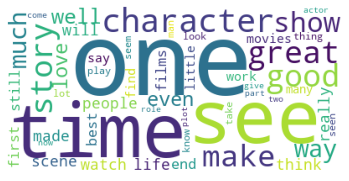

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(CommonWords))

# Generate and plot wordcloud
plt.imshow(wc.generate(PosTrain_text))
plt.axis('off')
plt.show()

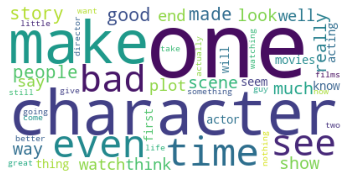

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(CommonWords))

# Generate and plot wordcloud
plt.imshow(wc.generate(NegTrain_text))
plt.axis('off')
plt.show()

In [16]:
tokenizer = Tokenizer(num_words=5000) # There's a bug here that I learned from working on the NMT project. Need to double check what the dictionaries look like.
tokenizer.fit_on_texts(X_train)

X_trainS = tokenizer.texts_to_sequences(X_train)
X_testS = tokenizer.texts_to_sequences(X_test)

In [17]:
w2i_dict = tokenizer.word_index
i2w_dict = tokenizer.index_word

In [21]:
X_train_Len = list(map(len,X_trainS))
print(min(X_train_Len), max(X_train_Len))
print(np.mean(X_train_Len), np.median(X_train_Len))
print(np.std(X_train_Len), np.var(X_train_Len))

6 1854
198.27804 150.0
144.20513005354005 20795.1195337584


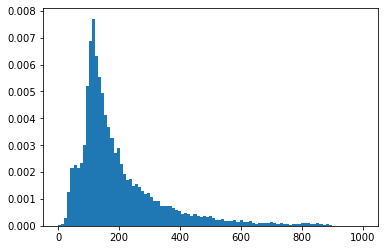

In [22]:
bins = np.linspace(0,1000,100)
_ = plt.hist(X_train_Len, bins = bins, density = True)
plt.show()

Since we capture most of the words once we have about 250-300 words. We can ignore the tail end of the other reviews. Those reviews are long....

In [18]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 300 # This errored when I had this at 300 before. Need to see why.

X_trainSP = pad_sequences(X_trainS, padding='post', maxlen=maxlen)
X_testSP = pad_sequences(X_testS, padding='post', maxlen=maxlen)

In [19]:
len(X_trainSP[0])

300

In [20]:
print(vocab_size)

75357


In [21]:
#vec_length = 50
vec_length = 100
#vec_length = 200
#vec_length = 300

# File Location:
glove_vectors = 'P&R_Project\glove.6B.{}d.txt'.format(str(vec_length))

# Load in embeddings
word2vec = dict()
with open(glove_vectors, 'r', encoding = "utf-8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split() #split at space
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32') #numpy.asarray()function is used when we want to convert input to an array.
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [27]:
print(len(word2vec['park']))
word2vec['park']

300


array([ 3.5629e-02,  1.9435e-01, -4.6777e-01, -3.6915e-02, -2.1932e-01,
       -3.1101e-04,  3.2824e-01,  2.3705e-02, -1.0264e-01, -4.5631e-01,
        2.6438e-01, -6.8960e-02, -5.1262e-02,  5.3643e-01, -1.4880e-01,
        3.8729e-01, -2.2161e-01, -3.2713e-03,  6.0177e-01,  1.5510e-01,
       -2.0279e-01,  3.5456e-03, -5.6226e-03,  4.8231e-01, -1.5697e-01,
        5.7566e-01, -5.4488e-01,  3.0075e-01, -4.7955e-01,  3.5704e-01,
        1.3527e+00,  1.7891e-01,  3.1932e-01,  3.9122e-01, -1.4440e-01,
        1.2477e-02, -2.0466e-01,  9.1306e-02, -5.5235e-01, -6.4101e-01,
        1.4303e-01,  3.0665e-01, -4.5290e-02,  1.3834e+00, -7.0074e-02,
       -2.8555e-01,  8.8993e-01,  1.2080e-01,  5.9364e-01,  3.4072e-01,
       -9.7112e-01, -5.0539e-01, -6.8830e-02,  1.8863e-01,  2.9484e-01,
        3.2003e-01,  7.3482e-01,  7.7389e-02, -1.0660e-01, -2.0786e-01,
        6.4910e-02,  5.0962e-02,  2.3740e-01,  3.9462e-01,  6.7148e-01,
       -4.5476e-01, -9.4335e-02,  4.3922e-02,  1.6793e-01, -4.28

In [22]:
# Create lookup of words to vectors
num_words = len(tokenizer.word_index)+1
#vec_length = 100

# New matrix to hold word embeddings
embedding_matrix = np.zeros((num_words, vec_length))

for word, index in tokenizer.word_index.items():
    embedding_vector = word2vec.get(word, None)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [29]:
embedding_matrix.shape

(75357, 300)

In [30]:
X_trainSP.shape

(25000, 300)

In [31]:
y_train.shape

(25000,)

In [33]:
model0 = Sequential()
#embedding_layer = Embedding(vocab_size, vec_length, weights=[embedding_matrix], input_length=maxlen , trainable=False)
embedding_layer = Embedding(input_dim = vocab_size, output_dim = vec_length,  weights=[embedding_matrix], input_length=maxlen, trainable=False)
model0.add(embedding_layer)

model0.add(Flatten())
model0.add(Dense(1, activation='sigmoid'))
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model0.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          22607100  
_________________________________________________________________
flatten (Flatten)            (None, 90000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 90001     
Total params: 22,697,101
Trainable params: 90,001
Non-trainable params: 22,607,100
_________________________________________________________________
None


In [35]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create callbacks
#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

# Create callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5), ModelCheckpoint('P&R_Project\model0.h5', save_best_only=True, save_weights_only=False)]

In [36]:
history0 = model0.fit(X_trainSP, y_train, batch_size=128, epochs=6, validation_split=0.2, callbacks=callbacks)

Epoch 1/6
157/157 [==============================] - 8s 54ms/step - loss: 0.5763 - accuracy: 0.7058 - val_loss: 0.5261 - val_accuracy: 0.7520
Epoch 2/6
157/157 [==============================] - 8s 48ms/step - loss: 0.2799 - accuracy: 0.8967 - val_loss: 0.5310 - val_accuracy: 0.7562
Epoch 3/6
157/157 [==============================] - 8s 48ms/step - loss: 0.1891 - accuracy: 0.9474 - val_loss: 0.5388 - val_accuracy: 0.7644
Epoch 4/6
157/157 [==============================] - 7s 47ms/step - loss: 0.1396 - accuracy: 0.9700 - val_loss: 0.5596 - val_accuracy: 0.7612
Epoch 5/6
157/157 [==============================] - 7s 47ms/step - loss: 0.1057 - accuracy: 0.9835 - val_loss: 0.6190 - val_accuracy: 0.7508
Epoch 6/6
157/157 [==============================] - 7s 47ms/step - loss: 0.0846 - accuracy: 0.9911 - val_loss: 0.6049 - val_accuracy: 0.7576


In [37]:
score0 = model0.evaluate(X_testSP, y_test)
print("Test Score:", score0[0])
print("Test Accuracy:", score0[1])

782/782 [==============================] - 8s 11ms/step - loss: 0.6132 - accuracy: 0.7565
Test Score: 0.6132313013076782
Test Accuracy: 0.7564799785614014


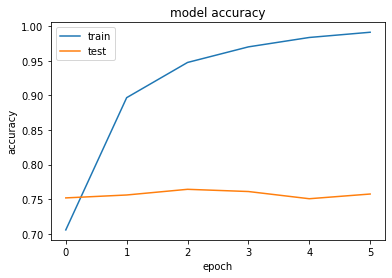

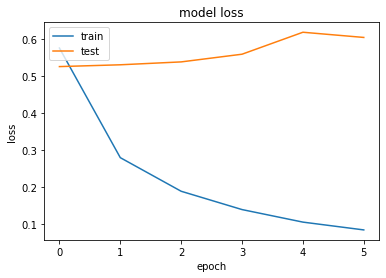

In [38]:
plt.plot(history0.history['accuracy'])
plt.plot(history0.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [39]:
model1 = Sequential()

embedding_layer = Embedding(input_dim = vocab_size, output_dim = vec_length,  weights=[embedding_matrix], input_length=maxlen, trainable=False)
model1.add(embedding_layer)

model1.add(Conv1D(128, 5, activation='relu'))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create callbacks
#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

# Create callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5), ModelCheckpoint('P&R_Project\model1.h5', save_best_only=True, save_weights_only=False)]

history1 = model1.fit(X_trainSP, y_train, batch_size=128, epochs=6, validation_split=0.2, callbacks=callbacks)
score1 = model1.evaluate(X_testSP, y_test)
print("Test Score:", score1[0])
print("Test Accuracy:", score1[1])

Epoch 1/6
157/157 [==============================] - 71s 451ms/step - loss: 0.4131 - accuracy: 0.8120 - val_loss: 0.3240 - val_accuracy: 0.8632
Epoch 2/6
157/157 [==============================] - 69s 441ms/step - loss: 0.2624 - accuracy: 0.8957 - val_loss: 0.2893 - val_accuracy: 0.8792
Epoch 3/6
157/157 [==============================] - 69s 443ms/step - loss: 0.1989 - accuracy: 0.9311 - val_loss: 0.2753 - val_accuracy: 0.8826
Epoch 4/6
157/157 [==============================] - 69s 436ms/step - loss: 0.1442 - accuracy: 0.9586 - val_loss: 0.2699 - val_accuracy: 0.8850
Epoch 5/6
157/157 [==============================] - 69s 438ms/step - loss: 0.1002 - accuracy: 0.9790 - val_loss: 0.2731 - val_accuracy: 0.8868
Epoch 6/6
782/782 [==============================] - 34s 44ms/step - loss: 0.2953 - accuracy: 0.8829
Test Score: 0.2952849864959717
Test Accuracy: 0.8829200267791748


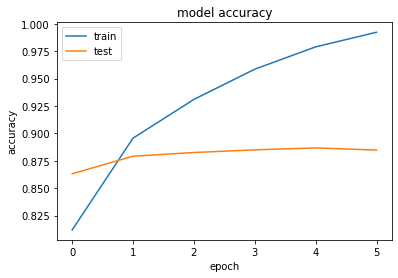

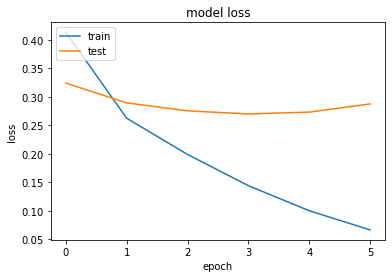

In [41]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [42]:
model2 = Sequential()
embedding_layer = Embedding(input_dim = vocab_size, output_dim = vec_length,  weights=[embedding_matrix], input_length=maxlen, trainable=False)
model2.add(embedding_layer)
model2.add(LSTM(128))

model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create callbacks
#callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

# Create callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5), ModelCheckpoint('P&R_Project\model2.h5', save_best_only=True, save_weights_only=False)]


history2 = model2.fit(X_trainSP, y_train, batch_size=128, epochs=6, validation_split=0.2, callbacks=callbacks)
score2 = model2.evaluate(X_testSP, y_test)
print("Test Score:", score2[0])
print("Test Accuracy:", score2[1])

Epoch 1/6
157/157 [==============================] - 356s 2s/step - loss: 0.6885 - accuracy: 0.5257 - val_loss: 0.6867 - val_accuracy: 0.5128
Epoch 2/6
157/157 [==============================] - 371s 2s/step - loss: 0.6798 - accuracy: 0.5357 - val_loss: 0.6690 - val_accuracy: 0.5460
Epoch 3/6
157/157 [==============================] - 379s 2s/step - loss: 0.6733 - accuracy: 0.5579 - val_loss: 0.6851 - val_accuracy: 0.5234
Epoch 4/6
157/157 [==============================] - 401s 3s/step - loss: 0.6741 - accuracy: 0.5515 - val_loss: 0.6903 - val_accuracy: 0.5084
Epoch 5/6
157/157 [==============================] - 395s 3s/step - loss: 0.6839 - accuracy: 0.5319 - val_loss: 0.6835 - val_accuracy: 0.5382
Epoch 6/6
782/782 [==============================] - 140s 179ms/step - loss: 0.3860 - accuracy: 0.8429 - loss: 0.3861 
Test Score: 0.38603851199150085
Test Accuracy: 0.8429200053215027


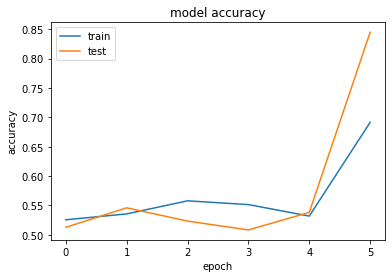

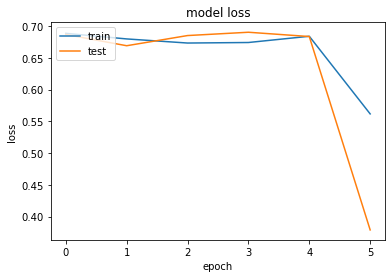

In [44]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Let's try using the models with the best one for each kind.

In [24]:
model0 = Sequential()
#embedding_layer = Embedding(vocab_size, vec_length, weights=[embedding_matrix], input_length=maxlen , trainable=False)
embedding_layer = Embedding(input_dim = vocab_size, output_dim = vec_length,  weights=[embedding_matrix], input_length=maxlen, trainable=False)
model0.add(embedding_layer)

model0.add(Flatten())
model0.add(Dense(1, activation='sigmoid'))
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model0.load_weights('P&R_Project\model0.h5')

In [25]:
model1 = Sequential()

embedding_layer = Embedding(input_dim = vocab_size, output_dim = vec_length,  weights=[embedding_matrix], input_length=maxlen, trainable=False)
model1.add(embedding_layer)

model1.add(Conv1D(128, 5, activation='relu'))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.load_weights('P&R_Project\model1.h5')

In [23]:
model2 = Sequential()
embedding_layer = Embedding(input_dim = vocab_size, output_dim = vec_length,  weights=[embedding_matrix], input_length=maxlen, trainable=False)
model2.add(embedding_layer)
model2.add(LSTM(128))

model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.load_weights('P&R_Project\model2.h5')

In [29]:
model0.summary()
score0 = model0.evaluate(X_testSP, y_test)
print("Test Score:", score0[0])
print("Test Accuracy:", score0[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          22607100  
_________________________________________________________________
flatten (Flatten)            (None, 90000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 90001     
Total params: 22,697,101
Trainable params: 90,001
Non-trainable params: 22,607,100
_________________________________________________________________
782/782 [==============================] - 9s 11ms/step - loss: 0.5275 - accuracy: 0.7502
Test Score: 0.5274810194969177
Test Accuracy: 0.7502400279045105


In [30]:
model1.summary()
score1 = model1.evaluate(X_testSP, y_test)
print("Test Score:", score1[0])
print("Test Accuracy:", score1[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          22607100  
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 128)          192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 22,799,357
Trainable params: 192,257
Non-trainable params: 22,607,100
_________________________________________________________________
782/782 [==============================] - 34s 44ms/step - loss: 0.2736 - accuracy: 0.8858
Test Score: 0.2735897898674011
Test Accuracy: 0.8858000040054321


In [31]:
model2.summary()
score2 = model2.evaluate(X_testSP, y_test)
print("Test Score:", score2[0])
print("Test Accuracy:", score2[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          22607100  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 22,826,877
Trainable params: 219,777
Non-trainable params: 22,607,100
_________________________________________________________________
782/782 [==============================] - 55s 70ms/step - loss: 0.3860 - accuracy: 0.8429
Test Score: 0.38603851199150085
Test Accuracy: 0.8429200053215027


In [159]:
SampleReview = 'Wow! That movie was amazing. I believe that was the best movie ever.'
#SampleReview = 'Best movie ever!'
SRP = preprocess_text(SampleReview)
print(SRP)
Res = tokenizer.texts_to_sequences(np.array([SRP]))
print(Res)
psres = pad_sequences(Res,padding='post', maxlen=maxlen)
print(model0.predict(psres))
print(model1.predict(psres))
print(model2.predict(psres))

Wow That movie was amazing believe that was the best movie ever 
[[1338, 9, 12, 10, 473, 254, 9, 10, 1, 111, 12, 118]]
[[0.47030538]]
[[0.99443555]]
[[0.8251147]]


First model predicts negative, but the other two models predicts positive.

In [165]:
j = 10
print(X_trainSP[j][X_trainSP[j]>0])
text = ' '.join(tokenizer.index_word[ind] for ind in X_trainSP[j][X_trainSP[j]>0])
print(text)
print(model0.predict(X_trainSP[j].reshape(1,-1)), y_train[j])
print(model1.predict(X_trainSP[j].reshape(1,-1)), y_train[j])
print(model2.predict(X_trainSP[j].reshape(1,-1)), y_train[j])
#SRP = preprocess_text(text)
#print(SRP)
#Res = tokenizer.texts_to_sequences(np.array([SRP]))
#print(Res)
#psres = pad_sequences(Res,padding='post', maxlen=maxlen)
#print(model0.predict(psres))
#print(model1.predict(psres))
#print(model2.predict(psres))

[   1  768 2034  118   86    8   12    5  216    7   92    9   52   72
 2034  118   42  213  494    7  389    6   42  169  144    7    6    9
   17   55  181    7 2034   12   52   72 2034   12  118   42   36  118
   75 2077    1   99    8   65   55  131    9   41   17   23  103 2034
   12    2  407    6   17  140   61    8   24   17   75  107    6    2
   41   17   23  108  103 2034   17  140   61    8   24    2  786    1
  366    3   87]
the greatest tarzan ever made this movie is done in way that no other tarzan ever has come close in doing it has every thing in it that you would want in tarzan movie no other tarzan movie ever has or ever will portray the character this well would say that if you have seen tarzan movie and liked it you should see this one you will love it and if you have never seen tarzan you should see this one and forget the rest of them
[[0.48765707]] 1
[[0.93918025]] 1
[[0.83060765]] 1


# Created functions to create and evaluate models based on hyper-parameters.

In [183]:
from keras.callbacks import EarlyStopping

In [184]:
def createM0(batchsize=128, epochnum=6):
    print('Batch size: {} \ Epoch: {}'.format(batchsize, epochnum))
    model = Sequential()
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = vec_length,  weights=[embedding_matrix], input_length=maxlen, trainable=False)
    model.add(embedding_layer)
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]#, ModelCheckpoint('P&R_Project\model1.h5', save_best_only=True, save_weights_only=False)]
    history = model.fit(X_trainSP, y_train, batch_size=batchsize, epochs=epochnum, validation_split=0.2, callbacks=callbacks)
    score = model.evaluate(X_testSP, y_test)
    print('Loss Score: {} \ Accuracy Score: {}'.format(score[0],score[1]))
    return score

In [185]:
def createM1(NumberCovID=128, windowval = 5, batchsize=128, epochnum=6):
    print('NumberCovID: {} \ windowval: {} \ Batch size: {} \ Epoch: {}'.format(NumberCovID, windowval, batchsize, epochnum))
    model = Sequential()
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = vec_length,  weights=[embedding_matrix], input_length=maxlen, trainable=False)
    model.add(embedding_layer)
    model.add(Conv1D(NumberCovID, windowval, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]#, ModelCheckpoint('P&R_Project\model1.h5', save_best_only=True, save_weights_only=False)]
    history = model.fit(X_trainSP, y_train, batch_size=batchsize, epochs=epochnum, validation_split=0.2, callbacks=callbacks)
    score = model.evaluate(X_testSP, y_test)
    print('Loss Score: {} \ Accuracy Score: {}'.format(score[0],score[1]))
    return score

In [186]:
def createM2(NumberLSTM=128, batchsize=128, epochnum=6):
    print('LSTM: {} \ Batch size: {} \ Epoch: {}'.format(NumberLSTM, batchsize, epochnum))
    model = Sequential()
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = vec_length,  weights=[embedding_matrix], input_length=maxlen, trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(NumberLSTM))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]#, ModelCheckpoint('P&R_Project\model1.h5', save_best_only=True, save_weights_only=False)]
    history = model.fit(X_trainSP, y_train, batch_size=batchsize, epochs=epochnum, validation_split=0.2, callbacks=callbacks)
    score = model.evaluate(X_testSP, y_test)
    print('Loss Score: {} \ Accuracy Score: {}'.format(score[0],score[1]))
    return score

In [187]:
NumberCovIDList = [64, 128, 256]
windowvalList = [3, 5, 7]
NumberLSTMList = [64, 128, 256]
batchsizeList = [64, 128, 256]
epochnumList = [6, 12, 18]

In [188]:
for epochnum in epochnumList:
    for batchsize in batchsizeList:
        createM0(batchsize, epochnum)

Batch size: 64 \ Epoch: 6
Epoch 1/6
313/313 [==============================] - 8s 25ms/step - loss: 0.6065 - accuracy: 0.6993 - val_loss: 0.5384 - val_accuracy: 0.7512
Epoch 2/6
313/313 [==============================] - 8s 25ms/step - loss: 0.2678 - accuracy: 0.8952 - val_loss: 0.5516 - val_accuracy: 0.7602
Epoch 3/6
313/313 [==============================] - 8s 25ms/step - loss: 0.1599 - accuracy: 0.9536 - val_loss: 0.5899 - val_accuracy: 0.7572
Epoch 4/6
313/313 [==============================] - 8s 25ms/step - loss: 0.1089 - accuracy: 0.9762 - val_loss: 0.6049 - val_accuracy: 0.7604
Epoch 5/6
313/313 [==============================] - 8s 25ms/step - loss: 0.0789 - accuracy: 0.9887 - val_loss: 0.6427 - val_accuracy: 0.7578
Epoch 6/6
782/782 [==============================] - 8s 11ms/step - loss: 0.6711 - accuracy: 0.7536
Loss Score: 0.6710565090179443 \ Accuracy Score: 0.7536399960517883
Batch size: 128 \ Epoch: 6
Epoch 1/6
157/157 [==============================] - 8s 49ms/step - l

In [190]:
for epochnum in epochnumList:
    for batchsize in batchsizeList:
        for NumberCovID in NumberCovIDList:
            for windowval in windowvalList:
                createM1(NumberCovID, windowval, batchsize, epochnum)

NumberCovID: 64 \ windowval: 3 \ Batch size: 64 \ Epoch: 6
Epoch 1/6
313/313 [==============================] - 38s 123ms/step - loss: 0.4123 - accuracy: 0.8117 - val_loss: 0.3146 - val_accuracy: 0.8664
Epoch 2/6
313/313 [==============================] - 38s 120ms/step - loss: 0.2830 - accuracy: 0.8841 - val_loss: 0.3146 - val_accuracy: 0.8652
Epoch 3/6
313/313 [==============================] - 38s 120ms/step - loss: 0.2324 - accuracy: 0.9096 - val_loss: 0.2765 - val_accuracy: 0.8846
Epoch 4/6
313/313 [==============================] - 38s 120ms/step - loss: 0.1955 - accuracy: 0.9284 - val_loss: 0.3013 - val_accuracy: 0.8722
Epoch 5/6
313/313 [==============================] - 38s 120ms/step - loss: 0.1585 - accuracy: 0.9456 - val_loss: 0.2775 - val_accuracy: 0.8836
Epoch 6/6
782/782 [==============================] - 17s 22ms/step - loss: 0.2977 - accuracy: 0.8780
Loss Score: 0.2976531386375427 \ Accuracy Score: 0.8779600262641907
NumberCovID: 64 \ windowval: 5 \ Batch size: 64 \ Ep

In [191]:
for epochnum in epochnumList:
    for batchsize in batchsizeList:
        for NumberLSTM in NumberLSTMList:
            createM2(NumberLSTM, batchsize, epochnum)

LSTM: 64 \ Batch size: 64 \ Epoch: 6
Epoch 1/6
313/313 [==============================] - 38s 121ms/step - loss: 0.6829 - accuracy: 0.5296 - val_loss: 0.6657 - val_accuracy: 0.5456
Epoch 2/6
313/313 [==============================] - 40s 128ms/step - loss: 0.6817 - accuracy: 0.5312 - val_loss: 0.6787 - val_accuracy: 0.5422
Epoch 3/6
313/313 [==============================] - 44s 141ms/step - loss: 0.6802 - accuracy: 0.5426 - val_loss: 0.6687 - val_accuracy: 0.5434
Epoch 4/6
313/313 [==============================] - 49s 156ms/step - loss: 0.6734 - accuracy: 0.5401 - val_loss: 0.6784 - val_accuracy: 0.5230
Epoch 5/6
313/313 [==============================] - 52s 165ms/step - loss: 0.6648 - accuracy: 0.5415 - val_loss: 0.6588 - val_accuracy: 0.5448
Epoch 6/6
782/782 [==============================] - 35s 45ms/step - loss: 0.4617 - accuracy: 0.8143
Loss Score: 0.46168941259384155 \ Accuracy Score: 0.8142799735069275
LSTM: 128 \ Batch size: 64 \ Epoch: 6
Epoch 1/6
313/313 [================

ResourceExhaustedError:    OOM when allocating tensor with shape[300,128,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node TensorArrayV2Stack/TensorListStack}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[sequential_108/lstm_14/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_718503]

Function call stack:
test_function -> test_function -> test_function


At this point computer bugged out and crashed. From a quick look, the best accuracy was between 85-90% depending on the choice of hyper-parameters and models.

More work will be will done to clean up this notebook, and also to optimize the model better.